In [438]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df_train processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
""" 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
 """
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

" \nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n "

# 1. Чтение данных из файлов

In [439]:
# df_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
# df_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# 2. Предварительный анализ данных

In [440]:

transported = df_train['Transported'].value_counts()
transported

Transported
True     4378
False    4315
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x259d2b67a50>,
 [Text(-0.012522008688130765, 1.0999287246446539, 'True'),
  Text(0.01252200868813063, -1.0999287246446539, 'False')],
 [Text(-0.006830186557162235, 0.5999611225334475, '50.4%'),
  Text(0.006830186557162161, -0.5999611225334475, '49.6%')])

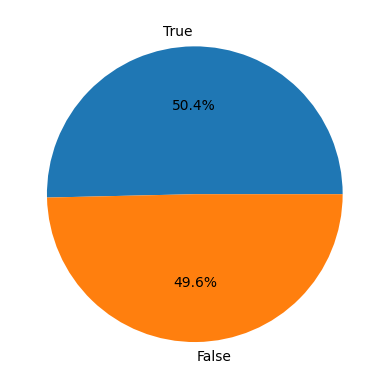

In [441]:
plt.pie(transported, labels=['True', 'False'], autopct='%1.1f%%')


df_train.isnull().sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
vip_cryo = df_train[df_train['VIP'] == True]['CryoSleep'].value_counts()
ax1.pie(vip_cryo, labels=['True', 'False'], autopct='%1.1f%%')
ax1.set_title('VIP/CryoSleep')

not_vip_cryo = df_train[df_train['VIP'] == False]['CryoSleep'].value_counts()
ax2.pie(not_vip_cryo, labels=['True', 'False'], autopct='%1.1f%%')
ax2.set_title('Не VIP/CryoSleep')

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
alive_cryo = df_train[df_train['Transported'] == False]['CryoSleep'].value_counts()
ax1.pie(alive_cryo, labels=['True', 'False'], autopct='%1.1f%%')
ax1.set_title('Оставшиеся/CryoSleep')

dead_cryo = df_train[df_train['Transported'] == True]['CryoSleep'].value_counts()
ax2.pie(dead_cryo, labels=['True', 'False'], autopct='%1.1f%%')
ax2.set_title('Попавшие в альтернативную вселенную/CryoSleep')

plt.tight_layout()
plt.show()

# 3. Предобработка данных

In [442]:
df_train.fillna({'Age': df_train['Age'].median()}, inplace=True)
df_train.fillna({'HomePlanet': 'Unknown'}, inplace=True)
df_train.fillna({'CryoSleep': False}, inplace=True)
df_train.fillna({'RoomService': df_train['RoomService'].median()}, inplace=True)
df_train.fillna({'FoodCourt': df_train['FoodCourt'].median()}, inplace=True)
df_train.fillna({'ShoppingMall': df_train['ShoppingMall'].median()}, inplace=True)
df_train.fillna({'Spa': df_train['Spa'].median()}, inplace=True)
df_train.fillna({'VRDeck': df_train['VRDeck'].median()}, inplace=True)

df_test.fillna({'Age': df_test['Age'].median()}, inplace=True)
df_test.fillna({'HomePlanet': 'Unknown'}, inplace=True)
df_test.fillna({'CryoSleep': False}, inplace=True)
df_test.fillna({'RoomService': df_test['RoomService'].median()}, inplace=True)
df_test.fillna({'FoodCourt': df_test['FoodCourt'].median()}, inplace=True)
df_test.fillna({'ShoppingMall': df_test['ShoppingMall'].median()}, inplace=True)
df_test.fillna({'Spa': df_test['Spa'].median()}, inplace=True)
df_test.fillna({'VRDeck': df_test['VRDeck'].median()}, inplace=True)

# df_train['CryoSleep'] = df_train.apply(lambda x: True if x['VIP'] == True else False, axis=1)

C:\Users\cold1\AppData\Local\Temp\ipykernel_20328\306675529.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train.fillna({'CryoSleep': False}, inplace=True)
C:\Users\cold1\AppData\Local\Temp\ipykernel_20328\306675529.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test.fillna({'CryoSleep': False}, inplace=True)


In [443]:
# Преобразуем категориальные переменные в числовые
df_train = pd.get_dummies(df_train, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], drop_first=True)
df_train[['CabinDeck', 'CabinNum', 'CabinSide']] = df_train['Cabin'].str.split('/', expand=True)

le_cabinDeck = LabelEncoder()
le_cabinNum = LabelEncoder()
le_cabinSide = LabelEncoder()

df_train['CabinDeck'] = le_cabinDeck.fit_transform(df_train['CabinDeck'])
df_train['CabinNum'] = le_cabinNum.fit_transform(df_train['CabinNum'])
df_train['CabinSide'] = le_cabinSide.fit_transform(df_train['CabinSide'])

In [444]:

df_test = pd.get_dummies(df_test, columns=['HomePlanet', 'CryoSleep', 'Destination', 'VIP'], drop_first=True)
df_test[['CabinDeck', 'CabinNum', 'CabinSide']] = df_test['Cabin'].str.split('/', expand=True)

df_test['CabinDeck'] = le_cabinDeck.fit_transform(df_test['CabinDeck'])
df_test['CabinNum'] = le_cabinNum.fit_transform(df_test['CabinNum'])
df_test['CabinSide'] = le_cabinSide.fit_transform(df_test['CabinSide'])

In [445]:
# Извлекаем данные для обучения и целевую переменную
X = df_train.drop(columns=['PassengerId', 'Name', 'Cabin', 'Transported'])
y = df_train['Transported'].astype(int)

X_train = X
y_train = y
X_test = df_test.drop(columns=['PassengerId', 'Cabin', 'Name'])
X_train

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Unknown,CryoSleep_True,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_True,CabinDeck,CabinNum,CabinSide
0,39.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,False,True,False,1,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,False,False,False,False,False,True,False,5,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,True,False,False,False,False,True,True,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,True,False,False,False,False,True,False,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,False,False,False,False,False,True,False,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,True,False,False,False,False,False,True,0,1795,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,True,False,False,6,548,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,False,False,False,False,False,True,False,6,551,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,True,False,False,False,False,False,False,4,1385,1


In [446]:
# 3. Разделяем данные на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [447]:
# 4. Обучаем модель
xgb = XGBClassifier(objective='binary:logistic',random_state=42)

cv_params = {
    'max_depth':[None,2,3,4,5],
    'min_child_weight':[4,5,6],
    'learning_rate': [0.01,0.05,0.1,0.2],
    'n_estimators':[150,200,300]
}

model = GridSearchCV(xgb,cv_params,cv=4,refit='accuracy')
model.fit(X_train, y_train)

# 5. Оцениваем модель
y_pred = model.predict(X_valid)

print()
# 6. Выводим результаты
print("Accuracy:", accuracy_score(y_valid, y_pred))

print(model.best_params_)


Accuracy: 0.8016101207590569
{'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 150}


In [448]:
# y_pred = y_pred.astype(bool)
# submission = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Transported': y_pred})
# original = pd.read_csv('submission.csv')
# print((submission == original).sum(False))
# submission.to_csv('submission.csv', index=False)
# 0.8016